In [1]:
import  os, sys
import  matplotlib.pyplot as plt
import yaml
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
sys.path.append('../')  # Add parent dir to path
import hardware
from scipy.spatial.transform import Rotation as R

In [2]:
def mjd_to_hours(mjd):
    seconds_per_day = 86400  # 24 hours * 60 minutes * 60 seconds
    mjd_epoch = 2400000.5  # JD of MJD
    
    # MJD --> JD
    jd = mjd + mjd_epoch
    
    # JD --> hrs since start
    hours_since_start = (jd - jd.iloc[0]) * 24
    
    return hours_since_start

def cart_to_alt_az(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    # az in rad
    theta = np.arctan2(y, x)  # arctan2 handles the correct quadrant of the angle
    # pol angle
    phi = np.arccos(z / r)
    # polar angle to altitude in degrees
    alt = np.degrees(np.pi/2 - phi)  # pi/2 - phi to convert polar angle to altitude
    # az to deg
    az = np.degrees(theta)
    return alt, az

In [3]:
class Panel: # base, "abstract"

    name            ='Base Panel Class' # will be overwritten in the derived classes
    verbose         = True
    solarConstant   = 1361   # W/m^2 at Moon 

    ###
    def __init__(self, sun, name = '', lander=(0.0 , 0.0, 0.0), normal=(None, None, None), env=None, area=1.0, pvEFF_T=None, pvEFF_P=None, efficiency_mult=1.0, apply_cosine_correction=True, temperatures=None):

        lander_pitch, lander_roll, lander_yaw = lander
        

        r1 = R.from_euler('x', lander_pitch,    degrees=True) # + is nose down,     - is nose up
        r2 = R.from_euler('y', lander_roll,     degrees=True) # + is top left,      - is top right
        r3 = R.from_euler('z', lander_yaw,      degrees=True) # + is nose right,    - is nose left
        self.r_tot = r1*r2*r3

        self.sun        = sun
        self.name       = name
        self.area       = area
        self.env        = env
        self.efficiency_mult = efficiency_mult
        self.apply_cosine_correction = apply_cosine_correction

        if pvEFF_T is not None: 
            self.pvEfficiency = Panel.pvEfficiency
        else:
            self.pvEfficiency = np.polyfit(pvEFF_T, pvEFF_P, 2)
        
        # The "normal" is specific to each of the three (or more) subclassed panels
        self.normal     = normal
        self.normal_rot = self.r_tot.apply(self.normal)
        self.dot_sun    = self.dot(sun.xyz)
        self.dot_sun_corr = self.pv_angle_corr(sun.xyz)

        self.choice_list = [self.dot_sun, self.dot_sun, 0, 0]
        self.temperature = temperatures
    
    ### ---
    def dot(self, sun_xyz):
        buffer = self.area*np.dot(sun_xyz, self.normal_rot)
        buffer[buffer<0] = 0.0
        return buffer

    ### ---
    def pv_angle_corr(self, sun_xyz):
        #Correction factor for measured divergence of PV power as a function of solar angle from expected cosine/dot-product dependence 
        #Correction function derived from measured PV data in Ben Saliwanchik's lusee_pv_cosine_angle_correction.ipynb
        
        sun_unit = sun_xyz / np.linalg.norm(sun_xyz, axis=1)[:, np.newaxis] #Unit vector for direction of sun
        pv_unit = self.normal_rot / np.linalg.norm(self.normal_rot) #PV normal_rot should already be a unit vector, but hey, safety first!
        sun_angle = np.abs(np.degrees(np.arccos(np.dot(sun_unit, pv_unit)))) #Angle between sun and PV normal vector

        #Correction is modeled as high-order polynomial based on measured PV power as a function of angle
        poly_coeffs = [1.0004983419956408e+000, -3.8502838956781440e-003, 1.7502375769223580e-003, -3.5217013489873119e-004, 3.5446614736203286e-005, -2.0316555216327750e-006, \
                   7.1799275885981016e-008, -1.6233764365292121e-009, 2.3567637664937247e-011, -2.1265570389995531e-013, 1.0858756530544471e-015, -2.3977629606594377e-018]
        poly_fit = np.polynomial.Polynomial(poly_coeffs)

        return poly_fit(sun_angle)  
    
    ### ---
    def set_condition(self, condition_list):
        self.condition_list = condition_list

    ### ---
    def exposure(self):
        pwr = np.select(self.condition_list, self.choice_list)
        return pwr
    
    ### ---
    def power(self):
        eff = 0.3 # default, if the temperature curve is not set for the sun
    
        if self.temperature is not None: 
            eff = self.pvEfficiency(self.temperature)
            if self.apply_cosine_correction==True:
                power =  Panel.solarConstant*eff[:,0]*self.dot_sun_corr * self.efficiency_mult
        else:
            #power =  Panel.solarConstant*eff*np.select(self.condition_list, self.choice_list) * self.efficiency_mult
            eff = np.array(eff).reshape(-1, 1)
            power =  Panel.solarConstant*eff * self.efficiency_mult
        return power
    
    ### ---
    def info(self):
        return f'''Panel {self.name}'''
    
    ### Static method for the PV efficiency calculation (just convenient)
    @staticmethod
    def pvEfficiency(T):
        pvTemp = np.array([-173.15, 20, 126.85])
        pvPwr = np.array([152, 130, 110]) / 426.47  # Stated AM0 normal incidence power output of top panel
        p = np.poly1d(np.polyfit(pvTemp, pvPwr, 2))
        return p(T)

# ------------------------------------------------------------


In [4]:
class Sun_mr:
      def __init__(self,SolarX,SolarY,SolarZ,mjd,hrs):
            sun = np.zeros((len(SolarX),3))
            sun[:,0] = SolarX
            sun[:,1] = SolarY
            sun[:,2] = SolarZ

            #self.condition =  [self.alt>horizon+self.radius, self.alt>horizon, self.alt>horizon-self.radius, self.alt<=horizon-self.radius]
            self.xyz = sun
            self.mjd = mjd
            self.hrs = hrs
          


In [5]:
config = yaml.safe_load(open('../config/devices.yml','r'))
pcf= config['solar_panels']['config'] # panel config
panels  = config['solar_panels']['panels'] # list of panels
lander = np.array([float(x) for x in pcf['lander'].split()])
pvEFF_T = np.array([float(x) for x in pcf['PV_efficiency']['temp'].split()])
pvEFF_P = np.array([float(x) for x in pcf['PV_efficiency']['power'].split()])

cos_corr = pcf['apply_cosine_correction'] # Whether to apply correction to cosine-law for PV power as function of solar angle. Correction based on measured PV power. 


#print(eff.shape)

In [6]:
sol_pvt = pd.read_csv('sol_pow_RevA.csv',delimiter=',') ## loading in solar power data
sol_pvt['sol_hrs'] = mjd_to_hours(sol_pvt['Time (mjd)'])
#sol_pvt= sol_pvt[sol_pvt['sol_hrs'] < max(night1_coldpow['Nodes/Times'])]
#print(sol_pvt)


In [7]:
temperature_panel= np.zeros((len(sol_pvt['Panel E Temp']),3))
temperature_panel[:,0] = sol_pvt['Panel E Temp']
temperature_panel[:,1] = sol_pvt['Panel W Temp']
temperature_panel[:,2] = sol_pvt['Panel Top Temp']
sun = Sun_mr(sol_pvt['Solar X'],sol_pvt['Solar Y'],sol_pvt['Solar Z'],sol_pvt['Time (mjd)'],sol_pvt['sol_hrs'])

In [8]:
panel_list = []
for panel_name in panels:
    print(panels)
    panel = panels[panel_name]
    normal = np.array([float(x) for x in panel['normal'].split()])
    eff = panel['efficiency']*pcf['efficiency_all']
    print(eff)
    #print(eff.shape)
    panel = Panel(sun, name = '', lander=(0.0 , 0.0, 0.0), normal=normal, env=None, area=1.0, pvEFF_T= pvEFF_T, pvEFF_P=pvEFF_P , efficiency_mult=1.0, apply_cosine_correction=True, temperatures=temperature_panel)
    print(panel.power())
    panel_list.append(panel)
print(panel_list)

{'EPanel': {'normal': '1 0 0', 'efficiency': 1.0, 'area': 0.1565}, 'WPanel': {'normal': '-1 0 0', 'efficiency': 1.0, 'area': 0.1565}, 'TPanel': {'normal': '0 0 1', 'efficiency': 1.0, 'area': 0.313}}
1.0
[ 4.84827822e+02  4.84684287e+02  4.84540639e+02 ... -2.96208365e+08
 -2.94115269e+08 -2.91815324e+08]
{'EPanel': {'normal': '1 0 0', 'efficiency': 1.0, 'area': 0.1565}, 'WPanel': {'normal': '-1 0 0', 'efficiency': 1.0, 'area': 0.1565}, 'TPanel': {'normal': '0 0 1', 'efficiency': 1.0, 'area': 0.313}}
1.0
[-2.97585802e+08 -2.99386222e+08 -3.01007748e+08 ...  4.59030139e+02
  4.58763016e+02  4.58495777e+02]
{'EPanel': {'normal': '1 0 0', 'efficiency': 1.0, 'area': 0.1565}, 'WPanel': {'normal': '-1 0 0', 'efficiency': 1.0, 'area': 0.1565}, 'TPanel': {'normal': '0 0 1', 'efficiency': 1.0, 'area': 0.313}}
1.0
[-54.47055715 -37.73268149 -21.57735794 ... -24.38100312 -39.81678362
 -55.78489422]
[<__main__.Panel object at 0x7fa25c3da440>, <__main__.Panel object at 0x7fa2b4f795a0>, <__main__.Pan

Text(0.02, 0.5, 'P (watts)')

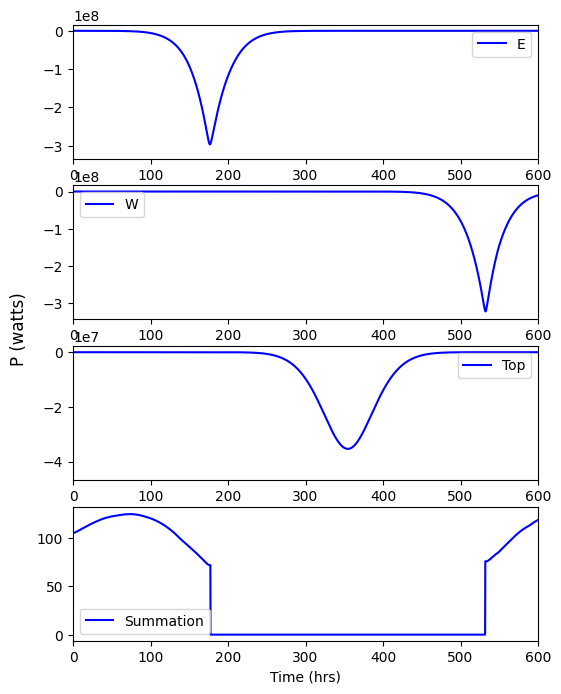

In [12]:
fig =plt.figure(figsize=(6, 8))
plt.subplot(4, 1, 1)
plt.plot(sol_pvt['sol_hrs']-180,  panel_list[0].power(), color ='blue' ,label='E')
plt.xlim(0,600)

plt.legend()
plt.subplot(4, 1, 2)
plt.plot(sol_pvt['sol_hrs']-180, panel_list[1].power(), color ='blue' ,label='W')
plt.xlim(0,600)

plt.legend()
plt.subplot(4, 1, 3)
plt.plot(sol_pvt['sol_hrs']-180,  panel_list[2].power(), color ='blue' ,label='Top')
plt.xlim(0,600)
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sol_pvt['sol_hrs']-180,  sol_pvt['Solar power (watts)'], color ='blue' ,label='Summation')
plt.xlabel('Time (hrs)')
plt.xlim(0,600)
plt.legend()
fig.supylabel('P (watts)')



# Reading solar panel model -- opsim

In [ ]:
sol_pvt = pd.read_csv('sol_pow_RevA.csv',delimiter=',') ## loading in solar power data
sol_pvt['sol_hrs'] = mjd_to_hours(sol_pvt['Time (mjd)'])

# Reading solar panel model -- Ryan

In [ ]:
sol_ryan = pd.read_csv('Night1_SolarPanels_354hrEclipse_240725.csv',delimiter=',') 
#sol_ryan = sol_ryan.T ## flips
#sol_ryan = sol_ryan.reset_index(drop=True) ## sets col
#sol_ryan.columns = sol_ryan.iloc[0] ## sets col
#sol_ryan = sol_ryan.drop(0) ## reindex
sol_pos = sol_ryan[51:56]
sol_pos = sol_pos.T 
sol_pos = sol_pos.reset_index(drop=True)
sol_pos.columns = sol_pos.iloc[0]
sol_pos = sol_pos.drop(0)

sol_pos = sol_pos[0:2550] ## end of data

#sol_ryan=sol_ryan.loc[:, ~sol_ryan.columns.duplicated()] ## remove duplicate columns
#sol_ryan['Nodes/Times'] = sol_ryan['Nodes/Times'].astype(float)

#sol_ryan['SOLAR_PNL_MX_AVG']= sol_ryan['SOLAR_PNL_MX_AVG'].astype(float)
#sol_ryan['SOLAR_PNL_PX_AVG']= sol_ryan['SOLAR_PNL_PX_AVG'].astype(float)
#sol_ryan['SOLAR_PNL_PZ_AVG']= sol_ryan['SOLAR_PNL_PZ_AVG'].astype(float)
sol_pos['SOLAR_X']= sol_pos['SOLAR_X'].astype(float)
sol_pos['SOLAR_Y']= sol_pos['SOLAR_Y'].astype(float)
sol_pos['SOLAR_Z']= sol_pos['SOLAR_Z'].astype(float)
sol_pos['Dir/Times']= sol_pos['Dir/Times'].astype(float)

sol_pos['alt'],sol_pos['az']= cart_to_alt_az(sol_pos['SOLAR_X'], sol_pos['SOLAR_Y'], sol_pos['SOLAR_Z'])


In [ ]:
fig =plt.figure(figsize=(6, 5))
plt.subplot(2, 1, 1)
plt.plot(sol_pos['Dir/Times']+180,  sol_pos['alt'], color ='red' ,label='Ryan-Alt')
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['alt'], color ='blue' ,label='Orig_Alt')

plt.legend()
plt.subplot(2, 1, 2)
plt.plot(sol_pos['Dir/Times']+180,  sol_pos['az'], color ='red' ,label='Ryan- Az')
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['az'], color ='blue' ,label='Orig- Az')
plt.xlabel('Time (hrs)')
plt.legend()
fig.supylabel('Degrees')

In [ ]:
fig =plt.figure(figsize=(6, 8))
plt.subplot(4, 1, 1)
plt.plot(sol_pos['Dir/Times']+180,  sol_pos['SOLAR_X'], color ='red' ,label='Ryan (X)')
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Solar X'], color ='blue' ,label='Orig (X)')

plt.legend()
plt.subplot(4, 1, 2)
plt.plot(sol_pos['Dir/Times']+180,  sol_pos['SOLAR_Y'], color ='red' ,label='Ryan (Y)')
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Solar Y'], color ='blue' ,label='Orig (Y)')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sol_pos['Dir/Times']+180,  sol_pos['SOLAR_Z'], color ='red' ,label='Ryan(Z)')
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Solar Z'], color ='blue' ,label='Orig(Z)')
plt.xlabel('Time (hrs)')
plt.legend()

#fig.supylabel('Alt (degrees)')

In [ ]:
fig =plt.figure(figsize=(6, 8))
plt.subplot(4, 1, 1)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel E Power'], color ='blue' ,label='E')

plt.legend()
plt.subplot(4, 1, 2)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel W Power'], color ='blue' ,label='W')

plt.legend()
plt.subplot(4, 1, 3)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel Top Power'], color ='blue' ,label='Top')

plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Solar power (watts)'], color ='blue' ,label='Summation')
plt.xlabel('Time (hrs)')
plt.legend()
fig.supylabel('P (watts)')



In [ ]:
fig =plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel E Temp'], color ='blue' ,label='E')
plt.plot(sol_ryan['Nodes/Times'][0:1300]+210,  sol_ryan['SOLAR_PNL_MX_AVG'][0:1300], color ='orange' ,label='E--Ryan (orig left)')
plt.plot(sol_ryan['Nodes/Times'][1300:]-500,  sol_ryan['SOLAR_PNL_MX_AVG'][1300:], color ='red' ,label='E--Ryan (orig right)')
plt.xlim(-30,600)
#plt.ylabel('P (watts)')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel W Temp'], color ='blue' ,label='W')
plt.plot(sol_ryan['Nodes/Times'][0:1300]+190,  sol_ryan['SOLAR_PNL_PX_AVG'][0:1300], color ='orange' ,label='W--Ryan (orig left)')
plt.plot(sol_ryan['Nodes/Times'][1300:]-520,  sol_ryan['SOLAR_PNL_PX_AVG'][1300:], color ='red' ,label='W--Ryan (orig right)')
plt.xlim(-30,600)
#plt.ylabel('P (watts)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel Top Temp'], color ='blue' ,label='Top')
plt.plot(sol_ryan['Nodes/Times'][0:1300]+190,  sol_ryan['SOLAR_PNL_PZ_AVG'][0:1300], color ='orange' ,label='Top--Ryan (orig left)')
plt.plot(sol_ryan['Nodes/Times'][1300:]-520,  sol_ryan['SOLAR_PNL_PZ_AVG'][1300:], color ='red' ,label='Top--Ryan (orig right)')
plt.xlabel('Time (hrs)')
plt.xlim(-30,600)
plt.legend()
